# Table of Contents
* [Set up environment](#env)
* [Read in Data](#load)
* [Univariate Analysis and Sanity Check](#uni)
    * [Remove Outliers](#out)
* [Bivariate Analysis](#biv)
    * [Variable Importance Pre-screening](#vip)
    * [Information Value](#iv)    
    * [Variable Linearity Check](#bub)
* [Banchmark Model: Logistic Regression](#log)
    * [Create Dummy Variables](#dum)
    * [Split Data](#spl)
    * [Build Logistic Regression](#log_model)
* [Challenge Model: Random Forest](#RF)
    * [Random Forest with Unrestricted Trees](#rf_un)
    * [Random Forest with Unrestricted Trees](#rf_sm)
* [Conclusions and Suggestions](#cs)

# Set up environment
<a id="env"></a> 

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import warnings
warnings.simplefilter('default')
from scipy import stats

# Read in Data
<a id="load"></a> 

In [2]:
# read in data
df = pd.read_csv("conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# Univariate Analysis and Sanity Check 
<a id="uni"> </a>

In [3]:
df.shape

(316200, 6)

In [4]:
# check the basic statistics of variables
df.describe(include='all')
# conclusion: numeric variable "age" is an outlier 123, need double check

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
# change new user to categorical variable
df['new_user'] = df['new_user'].apply(lambda x: str(x)) 

In [6]:
# check na
df.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [7]:
# check the frequency of categorical variables 'country'
df.groupby('country').agg({'country':'count'})

,country
country,
China,76602
Germany,13056
UK,48450
US,178092


In [8]:
df.groupby('new_user').agg({'new_user':'count'})

,new_user
new_user,
0,99456
1,216744


In [9]:
df.groupby('source').agg({'source':'count'})

,source
source,
Ads,88740
Direct,72420
Seo,155040


In [10]:
df.groupby('converted').agg({'converted':'count'})

,converted
converted,
0,306000
1,10200


52.0

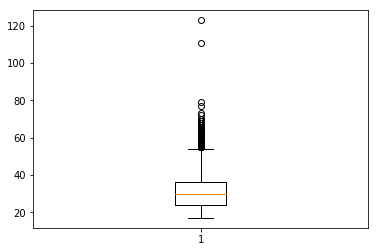

In [11]:
# check the outliers of numeric variables
plt.boxplot(df['age'])
np.percentile(df['age'],99)
# conclusion: by meaning, age >=100 are outliers

17.0

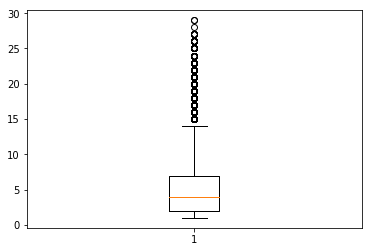

In [12]:
plt.boxplot(df['total_pages_visited'])
np.percentile(df['total_pages_visited'],99)
# conclusion: by meaning, total_pages_visited between 17 and 30 are not outliers

A few observations:

the site is probably a US site, although it does have a large Chinese user base as well user base is pretty young;

conversion rate at around 3% is industry standard. It makes sense.

everything seems to make sense here except for age outliers > 100 

## Remove Outliers  
<a id="out"> </a>

In [13]:
df[df['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Only two users are older than 100, and best way to treat those two users are deleting the two records

In [14]:
# delete the age>=100 records
df = df[df['age']<100]

# Bivariate Analysis
<a id="biv"> </a>

## Variable Importance Pre-screening
<a id="vip"> </a>

In [15]:
def Bivariate_freq_plot(df, pred, label):
    grouped = df[[pred, label]].groupby(pred).mean().reset_index()
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    sns.countplot(x = pred, hue = label, data = df, ax = ax[0])
    ax[0].set_title('Count Plot of ' + pred, fontsize = 16)
    ax[0].set_yscale('log')
    sns.barplot(x = pred, y = label, data = df, ax = ax[1]);
    ax[1].set_title('Mean Conversion Rate per ' + pred, fontsize = 16)
    plt.tight_layout()
    plt.show()
    return grouped

/Applications/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


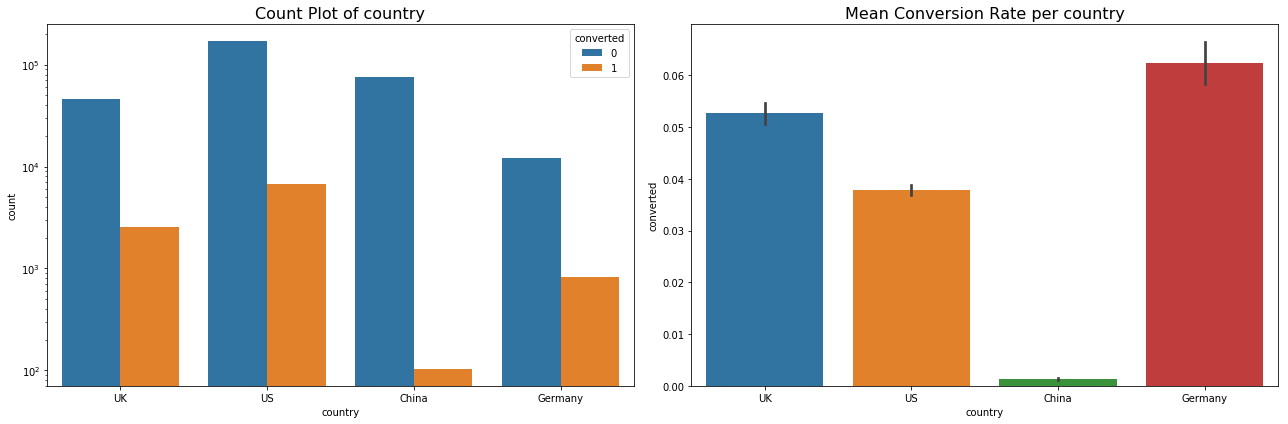

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


In [16]:
# Visualization of conversion rate vs countries
Bivariate_freq_plot(df = df, pred = 'country', label = 'converted')

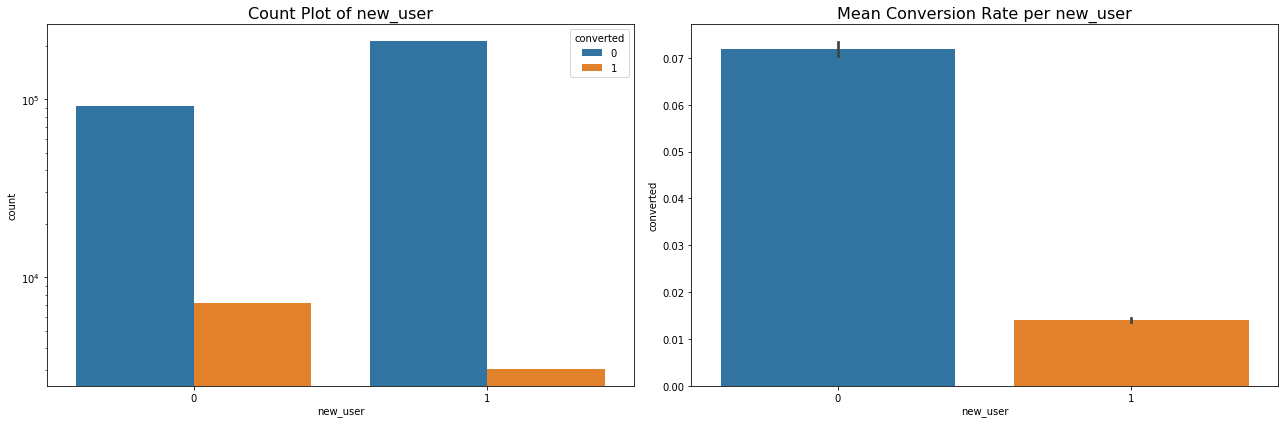

,new_user,converted
0,0,0.071983
1,1,0.014021


In [17]:
# Visualization of conversion rate vs countries
Bivariate_freq_plot(df = df, pred = 'new_user', label = 'converted')

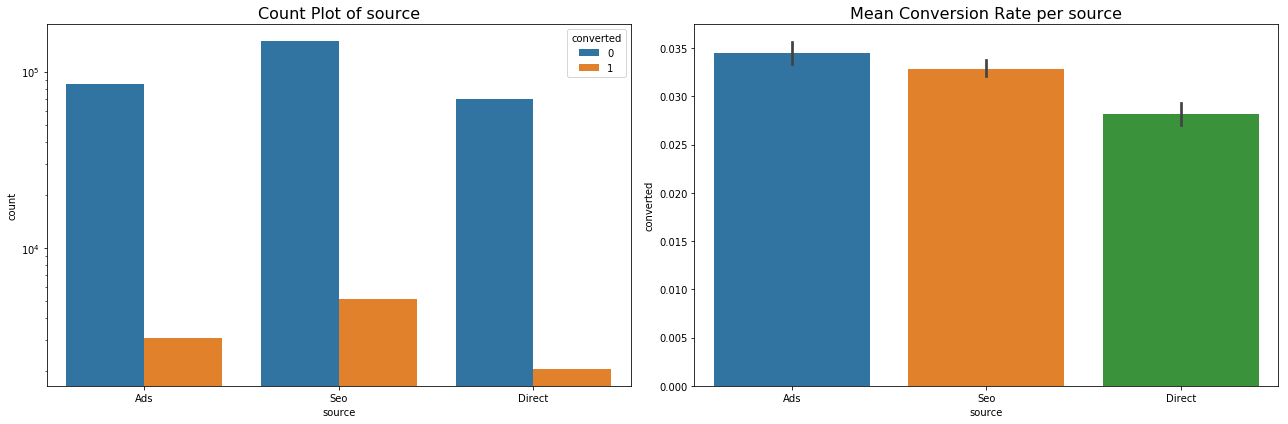

,source,converted
0,Ads,0.034472
1,Direct,0.028169
2,Seo,0.032888


In [18]:
# Visualization of conversion rate vs countries
Bivariate_freq_plot(df = df, pred = 'source', label = 'converted')

## Information Value
<a id="iv"> </a>

In [19]:
def info_calc(df, variable_list, target, ncat=20):
    summary = []
    for variable in variable_list:
        # cut bkt by percentile, ncat is the number of levels for a variable to be considered as continuous variable
        if df[variable].nunique()>= ncat:
            cut = pd.cut(df[variable], np.percentile(df[variable], [0, 20, 40, 60, 80, 100]), include_lowest = True)
            new_name = variable+'_bkt'
            cut.name = new_name
            bkt = pd.concat([df,cut],axis=1)
        else:
            new_name = variable+'_bkt'
            bkt = df.rename(columns={variable:new_name})
        # calculate the IV 
        lst = []
        for i in range(bkt[new_name].nunique()):
            val = list(bkt[new_name].unique())[i]
            lst.append([variable, val, bkt[bkt[new_name] == val].count()[new_name], bkt[(bkt[new_name] == val) & (bkt[target] == 1)].count()[new_name]])

        data = pd.DataFrame(lst, columns = ['Variable', 'Value', 'All', 'Bad'])
        data = data[data['Bad'] > 0]
        data['Bad Rate'] = data['Bad'] / data['All']
        data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
        data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
        data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
        data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()
        data = data.sort_values(by=['Variable', 'Value'], ascending=True)
        # append every variable to the summary table
        summary.append([variable, data['IV'].values[0]])
        
    summary = pd.DataFrame(summary, columns = ['Variable', 'IV'])
    summary = summary.sort_values(by = 'IV', ascending=True)
    return summary

In [20]:
info_calc(df, variable_list = ['country','age','new_user','source','total_pages_visited'], target = 'converted', ncat=20)

,Variable,IV
3,source,0.005758
1,age,0.274855
2,new_user,0.679229
0,country,0.867614
4,total_pages_visited,4.845186


## Variable Linearity Check
<a id="bub"> </a>

In [21]:
def bub_plot(df, variable, target, ncat=20):

    # cut bkt by percentile, ncat is the number of levels for a variable to be considered as continuous variable
    if df[variable].nunique()>= ncat:            
        cut = pd.cut(df[variable], np.percentile(df[variable], [0, 20, 40, 60, 80, 100]), include_lowest = True)
        new_name = variable+'_bkt'
        cut.name = new_name
        bkt = pd.concat([df,cut],axis=1)
    else:
        new_name = variable+'_bkt'
        bkt = df.rename(columns={variable:new_name})
    # calculate the Odds Ratio
    lst = []
    for i in range(bkt[new_name].nunique()):
        val = list(bkt[new_name].unique())[i]
        lst.append([variable, val, bkt[bkt[new_name] == val].count()[new_name], bkt[(bkt[new_name] == val) & (bkt[target] == 1)].count()[new_name]])

    data = pd.DataFrame(lst, columns = ['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]
    data['odds_ratio'] = np.log(data['Bad']/(data['All'] - data['Bad']))
    
    data['Value'] = data['Value'].apply(lambda x: str(x))
    data = data.sort_values(by= 'Value', ascending = True)
    
    
    plt.scatter(data['Value'], data['odds_ratio'], s=data['All']/200, alpha = 0.5)
    plt.xlabel(variable)
    plt.ylabel('log odds')
    plt.show()
    return None

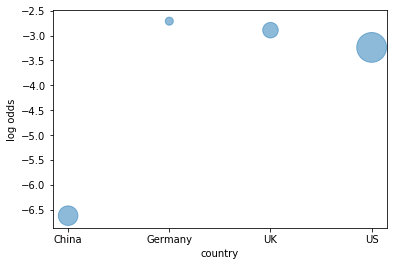

In [22]:
bub_plot(df, variable = 'country', target= 'converted', ncat=20)

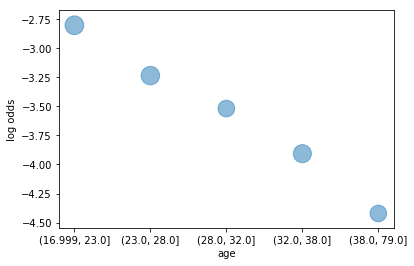

In [23]:
data = bub_plot(df, variable = 'age', target= 'converted', ncat=20)

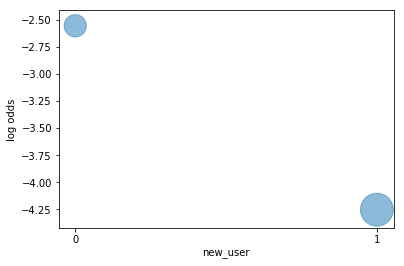

In [24]:
data = bub_plot(df, variable = 'new_user', target= 'converted', ncat=20)

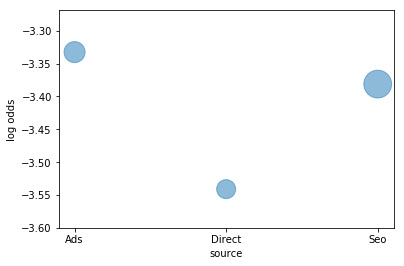

In [25]:
data = bub_plot(df, variable = 'source', target= 'converted', ncat=20)

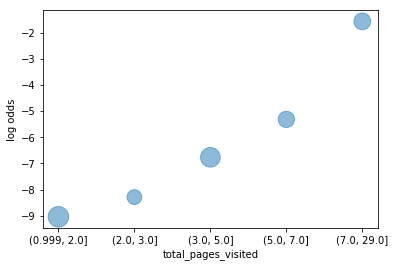

In [26]:
data = bub_plot(df, variable = 'total_pages_visited', target= 'converted', ncat=20)

Before building a ML model, we get a sense of the variable importance that:

1) Spending more time on the site implies higher probability of conversion

2) Chinese convert at a much lower rate than other countries

3) Ads is the best way to acquire users with high conversions

4) New_users are less likely to make conversions

5) Elder people are less likely to make conversions

# Banchmark Model： Losigtic Regression
<a id="log"> </a>

## Create Dummy Variables
<a id="dum"> </a>

In [27]:
# scikit-learn doesn't support transform categorical variables to numerical form automatically
# https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512
country_new = pd.get_dummies(data = df['country'], drop_first=True)
#country_new = country_new.loc[:,country_new.columns !='US']
source_new = pd.get_dummies(data = df['source'], drop_first=True)
#source_new = source_new.loc[:,source_new.columns !='Ads']
df_d = pd.concat([df,country_new, source_new], axis = 1) 
df_d = df_d.drop(['country','source'],axis = 1)

## Split Data
<a id="spl"> </a>

In [28]:
# Split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_d.loc[:,df_d.columns!='converted'],
                                                    df_d['converted'], test_size=0.33, random_state=42)

## Build Logistic Regression
<a id="log_model"> </a>

In [29]:
# Banchmark Model: Binary Logistic Regression Model, easy to interpret, use the L1 norm penalty to select variables
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1')
clf = logreg.fit(X_train,y_train)

In [30]:
# get learned coefficient table
coef = pd.DataFrame(clf.coef_)
coef.columns = df_d.columns[df_d.columns!='converted']
coef

,age,new_user,total_pages_visited,Germany,UK,US,Direct,Seo
0,-0.075914,-1.726382,0.756942,3.647299,3.445602,3.032493,-0.176368,-0.013113


In [31]:
clf.intercept_

array([-10.08345076])

In [32]:
# training sample accuracy
clf.score(X_train, y_train)

0.9858344504654193

In [33]:
# testing sample accuracy
clf.score(X_test, y_test)

0.986937688076208

In [34]:
# testing sample confusion matrix， the diagonal is the TP and TN
from sklearn.metrics import confusion_matrix
y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[100657    372]
 [   991   2326]]


In [35]:
# Precision = tp / (tp + fp)；recall = tp / (tp + fn) 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101029
          1       0.86      0.70      0.77      3317

avg / total       0.99      0.99      0.99    104346



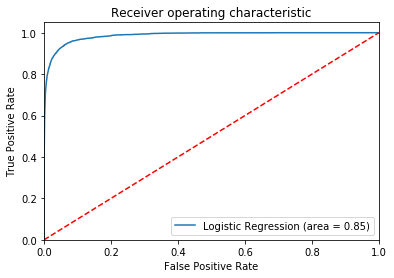

In [36]:
# AUC: TPR == Recall == sensitivity = tp / (tp + fn) ; FPR == fp/ (fp + tn)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

Model Performance Review： a. AUC on testing data: 0.85; b. Prediction accuracy on testing data: 98.69%
Model Interpretation:
The more page visited, the higher likelihood making conversions;
Compared to US, people in Germany and UK are more likely to make conversions, and visitors in China are less likely to make conversions;
New_users are less likely to make conversions;
Elder people are less likely to make conversions;
Ads is the most effective customer acquisition method to make conversions compared to Seo and Direct
Edit Metadata


# Challenge Model：Random Forest
<a id="RF"> </a>

## Random Forest with Unrestricted Trees
<a id="rf_un"> </a>

In [37]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
# Use the forest's predict method on the test data, the predicted value is the mean predicted regression targets of the trees in the forest
y_pred = rf.predict(X_test)

/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [38]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

In [39]:
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 0.02, 'degrees.')


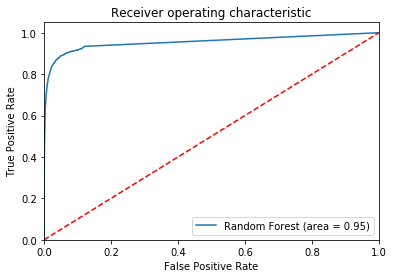

In [40]:
# AUC: TPR == Recall == sensitivity = tp / (tp + fn) ; FPR == fp/ (fp + tn)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# roc_auc_score: 1st argument: true label, 2nd argument: predicted probability
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test)) 
# roc_curve: 1st argument: true label, 2nd argument: predicted probability
fpr, tpr, thresholds = roc_curve(y_test, rf.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Forest_ROC')
plt.show()

In [41]:
feature_names = df_d.columns[df_d.columns!='converted']
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

['Variable: total_pages_visited  Importance: 0.76',
 'Variable: age                  Importance: 0.11',
 'Variable: new_user             Importance: 0.05',
 'Variable: Direct               Importance: 0.02',
 'Variable: Seo                  Importance: 0.02',
 'Variable: Germany              Importance: 0.01',
 'Variable: UK                   Importance: 0.01',
 'Variable: US                   Importance: 0.01']

## Random Forest with Smaller Trees
<a id="rf_sm"> </a>

In [42]:
from sklearn.tree import export_graphviz
import pydot
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = df_d.columns[df_d.columns!='converted'], rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

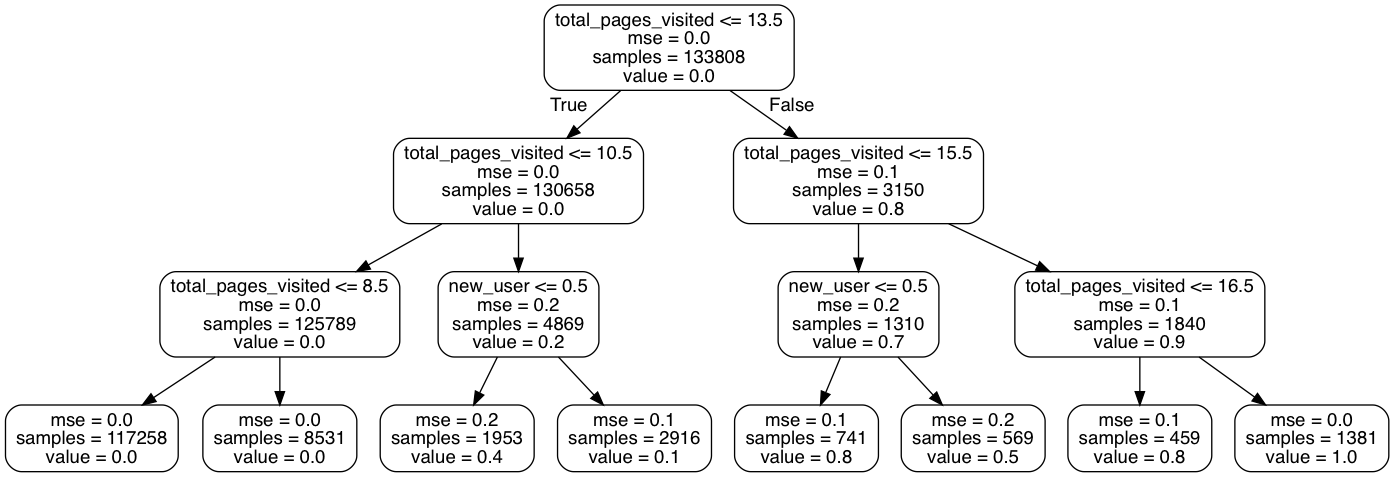

In [43]:
y_pred = rf_small.predict(X_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 0.02, 'degrees.')


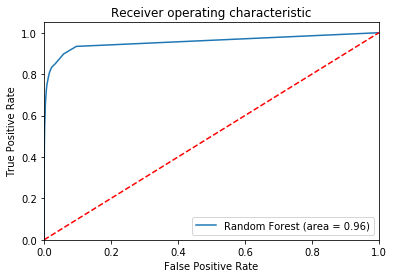

In [44]:
# AUC: TPR == Recall == sensitivity = tp / (tp + fn) ; FPR == fp/ (fp + tn)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# roc_auc_score: 1st argument: true label, 2nd argument: predicted probability
rf_roc_auc = roc_auc_score(y_test, rf_small.predict(X_test)) 
# roc_curve: 1st argument: true label, 2nd argument: predicted probability
fpr, tpr, thresholds = roc_curve(y_test, rf_small.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Forest_ROC')
plt.show()

# Conclusions and Suggestions
<a id="cs"> </a>

Some conclusions and suggestions:
1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.
4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why older users perform so poorly? F
6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.
As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones